# **Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over: Men**

https://fred.stlouisfed.org/series/LES1252881900Q

#TODO
* charger la serie temporelle
* plot
* tester si c'est un white noise: ljung box
* tester si c'est stationnaire
#AR(p) ?
* regarder PACF (partial autocorrelation)
* determiner l'ordre p du processus AR(p)



* calculer les coefficients d'autocorrelation

* trouver coefficients AR(p) avec Yule Walker
#MA(q) ?
* regarder ACF ( autocorrelation)
* determiner l'ordre q du processus MA(q)

* statsmodel fitter un processus ARMA

#Differencing - stationarisation
* processus $d_t = x_t - x_{t-1}$

In [1]:
import pandas as pd
import os
import sys

import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from dateutil import parser
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
url="/content/LES1252881900Q.csv"
df = pd.read_csv(url)

In [3]:
df.describe()

,LES1252881900Q
count,167.000000
mean,374.377246
std,12.401232
min,348.000000
25%,368.000000
50%,376.000000
75%,380.000000
max,427.000000


In [4]:
df.dtypes

DATE              object
LES1252881900Q     int64
dtype: object

In [5]:
df.DATE=pd.to_datetime(df.DATE)

In [6]:
df.dropna(inplace=True)
df.isnull().values.any()

False

In [7]:
ts = pd.Series(data = df.LES1252881900Q.values, index = df['DATE'])

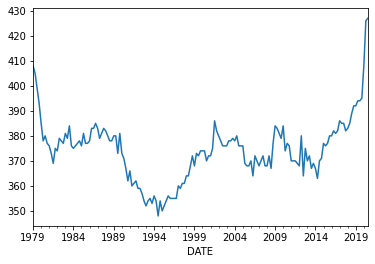

In [8]:
ts.plot()

In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        y.hist(bins = 20, ax = pp_ax)
        # scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [10]:
from statsmodels.tsa.stattools import adfuller

X = df['LES1252881900Q'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.425888
p-value: 0.982438
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


The H0 has been rejected, so our time series is non-stationary.

In [11]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from numpy import log

X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.249729
p-value: 0.974917
	1%: -3.472
	5%: -2.880
	10%: -2.577


we can say that we fail to reject the null hypothesis and in turn that the time series is non-stationary despite the transformation to log.

In [12]:
import statsmodels.api as sm
res = sm.stats.acorr_ljungbox(ts, lags=[5])
print(f"Resultat du test Ljung-Box p-value: {  res[1][0] }")

Resultat du test Ljung-Box p-value: 1.6468951996347108e-88


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


p-value << 0.5 donc on rejete H0: The data are independently distributed, so this isn't a, white noise.

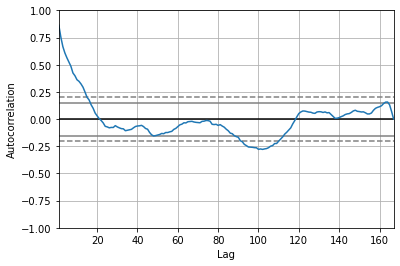

In [13]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(ts)
pyplot.show()

# KPSS Test de stationarité

In [14]:
from statsmodels.tsa.stattools import kpss
res = kpss(X)
print(f"la p-value est {res[1]} > 0.05 donc on ne peut pas rejeter H0: time series is stationary ")

la p-value est 0.1 > 0.05 donc on ne peut pas rejeter H0: time series is stationary 


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


On constate que Les 2 tests (ADF et KPSS) ne confirme pas que la serie n'est pas stationnaire tous les deux.

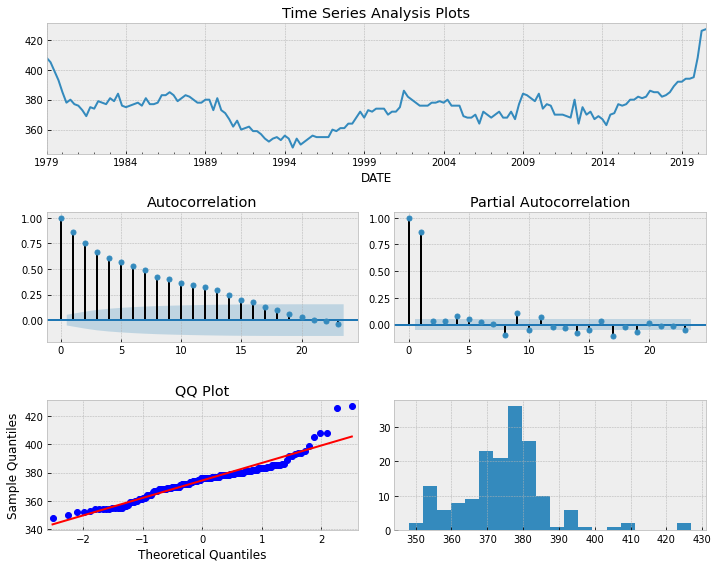

In [15]:
import statsmodels.tsa.api as smt
tsplot(ts)

#**processus simple AR(p)**



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


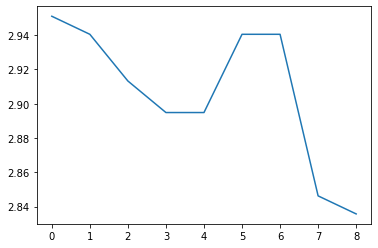

In [35]:
score = []
for i in range(1,10):
    mdl = smt.AR(ts.values).fit(maxlag=i, ic='aic', trend='c')
    # plt.plot(mdl.params)
    score.append(mdl.aic)
plt.plot(score)

l'ordre p du processus AR(p) est: 3

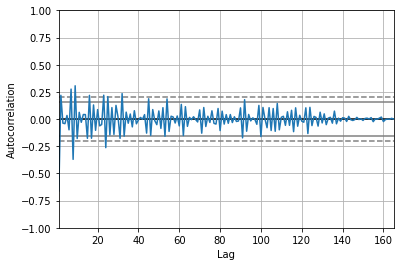

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(d2)
pyplot.show()

In [23]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.regression.linear_model import yule_walker
from math import sqrt

In [45]:
rho, sigma = yule_walker(train, order=3 , method="mle")
rho, sigma

(array([ 0.75920465,  0.16186346, -0.00860395]), 0.01197875510433545)

In [63]:
train, test = X[1:len(ts)-34], X[len(ts)-34:]
score_bic = []
score_mse = []
for i in range(1,60):
    model = AutoReg(train, lags=i)
    model_fit = model.fit()
    score_bic.append(model_fit.bic)
    n_fitted = len(model_fit.fittedvalues)
    score_mse.append( mse( model_fit.fittedvalues, train[:n_fitted]  )) 
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
 

Coefficients: [ 3.80090757e+00  5.67003174e-01  3.50000314e-01  1.24953475e-01
 -3.30889594e-01  2.20925099e-01  4.83243789e-02  1.70664907e-01
 -2.95154947e-01  8.39129641e-02  1.03821324e-01 -2.88789765e-01
 -4.05870749e-02  1.18104512e-02 -2.12968831e-01 -2.89413441e-01
  2.78242924e-01  1.03118209e-01  2.06107757e-02 -1.45969067e-01
  5.43987684e-01 -2.99379980e-02 -6.07090070e-02 -4.00053377e-02
  1.97443790e-01 -2.96936785e-01 -7.52744271e-02 -1.80790454e-01
 -1.95836010e-01  6.81969986e-02  2.02113801e-01 -2.68053307e-04
 -1.97266582e-01 -1.42010785e-02  1.72744418e-01 -5.58734952e-02
 -2.81469346e-02  1.83258241e-01  6.95517813e-02 -8.51781709e-02
 -8.95884578e-02  1.01673670e-01 -5.62277030e-03 -1.22407327e-01
 -1.65028885e-01 -6.81077222e-02 -8.24561654e-02  4.48981534e-01
 -3.00871575e-01 -7.08705577e-02  3.18467667e-01  6.26802828e-02
 -3.62737638e-01  2.17103533e-01  1.79642949e-01 -1.50625190e-01
 -1.68224838e-01 -9.41383653e-02  1.41087865e-01 -8.86443010e-02]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
 

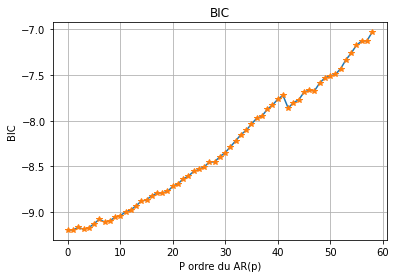

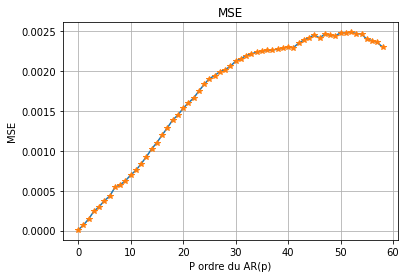

In [64]:
fig, ax = plt.subplots(1,1)
plt.title("BIC")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("BIC")
plt.plot(score_bic)
plt.plot(score_bic, '*')
plt.grid()

fig, ax = plt.subplots(1,1)
plt.title("MSE")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("MSE")
plt.plot(score_mse)
plt.plot(score_mse, '*')
plt.grid()

In [65]:
model = AutoReg(train, lags=42)
model_fit = model.fit()

print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

Coefficients: [ 0.99256411  0.63407401  0.30133511  0.26499339 -0.39097684  0.06275507
  0.02390309  0.31263359 -0.24711253  0.14134924 -0.08445324 -0.09247826
 -0.03820226  0.1006424  -0.13609584 -0.25861399  0.11621578  0.02792131
  0.15005835 -0.20936293  0.32036063 -0.08857087  0.09519713  0.00441289
  0.06965663 -0.1757291  -0.02655346 -0.04023482 -0.09455119  0.19056484
  0.07198501 -0.08899247 -0.08923789 -0.07204501 -0.0662086   0.11385669
  0.03438428  0.05345035 -0.08912458 -0.05379343  0.09809345  0.00878122
 -0.02225677]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


predicted=5.913747, expected=5.940171
predicted=5.902237, expected=5.897154
predicted=5.884901, expected=5.926926
predicted=5.881442, expected=5.913503
predicted=5.883887, expected=5.918894
predicted=5.869733, expected=5.905362
predicted=5.877079, expected=5.910797
predicted=5.891683, expected=5.905362
predicted=5.885057, expected=5.894403
predicted=5.893124, expected=5.913503
predicted=5.902664, expected=5.916202
predicted=5.905757, expected=5.932245
predicted=5.895549, expected=5.929589
predicted=5.904351, expected=5.932245
predicted=5.901309, expected=5.940171
predicted=5.892689, expected=5.940171
predicted=5.907360, expected=5.945421
predicted=5.916870, expected=5.942799
predicted=5.916364, expected=5.945421
predicted=5.914502, expected=5.955837
predicted=5.924566, expected=5.953243
predicted=5.913800, expected=5.953243
predicted=5.906034, expected=5.945421
predicted=5.913989, expected=5.948035
predicted=5.906421, expected=5.953243
predicted=5.891876, expected=5.963579
predicted=5.

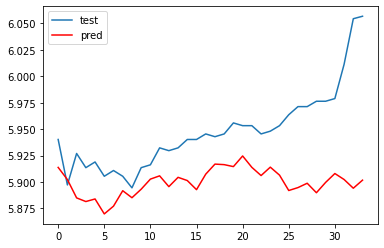

In [66]:
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test,label="test")
pyplot.plot(predictions, color='red',label="pred")
pyplot.legend()
pyplot.show()

#**MA(q)**

In [81]:
# MA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

# fit model
model = ARIMA(train, order=(0, 0, 32))
model_fit = model.fit()
# make prediction
yhat =  model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print(yhat)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[5.91894474 5.90891046 5.90188777 5.90202697 5.90515336 5.90510962
 5.90385453 5.91421747 5.91110949 5.92056735 5.92259973 5.92317378
 5.9180094  5.9221396  5.92637551 5.92195833 5.93032591 5.93090705
 5.92923824 5.92989563 5.93058033 5.93011566 5.92607334 5.92958392
 5.92374471 5.92271468 5.92361462 5.92192795 5.92388372 5.92371619
 5.92420346 5.92445989 5.92421515 5.92421515]


yhat=5.918945, expected=5.940171
yhat=5.908910, expected=5.897154
yhat=5.901888, expected=5.926926
yhat=5.902027, expected=5.913503
yhat=5.905153, expected=5.918894
yhat=5.905110, expected=5.905362
yhat=5.903855, expected=5.910797
yhat=5.914217, expected=5.905362
yhat=5.911109, expected=5.894403
yhat=5.920567, expected=5.913503
yhat=5.922600, expected=5.916202
yhat=5.923174, expected=5.932245
yhat=5.918009, expected=5.929589
yhat=5.922140, expected=5.932245
yhat=5.926376, expected=5.940171
yhat=5.921958, expected=5.940171
yhat=5.930326, expected=5.945421
yhat=5.930907, expected=5.942799
yhat=5.929238, expected=5.945421
yhat=5.929896, expected=5.955837
yhat=5.930580, expected=5.953243
yhat=5.930116, expected=5.953243
yhat=5.926073, expected=5.945421
yhat=5.929584, expected=5.948035
yhat=5.923745, expected=5.953243
yhat=5.922715, expected=5.963579
yhat=5.923615, expected=5.971262
yhat=5.921928, expected=5.971262
yhat=5.923884, expected=5.976351
yhat=5.923716, expected=5.976351
yhat=5.924

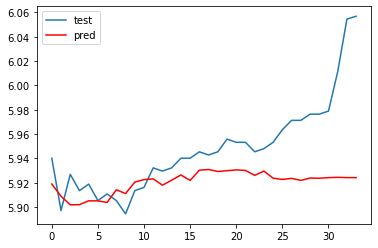

In [82]:
for i in range(len(yhat)):
	print('yhat=%f, expected=%f' % (yhat[i], test[i]))
rmse = sqrt(mean_squared_error(test, yhat))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test,label="test")
pyplot.plot(yhat, color='red',label="pred")
pyplot.legend()
pyplot.show()

#Differencing - stationarisation

la p-value est 0.04687228323462214 << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  
la p-value est 0.03529669969867881 < 0.05 donc on peut rejeter H0: time series is stationary 


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


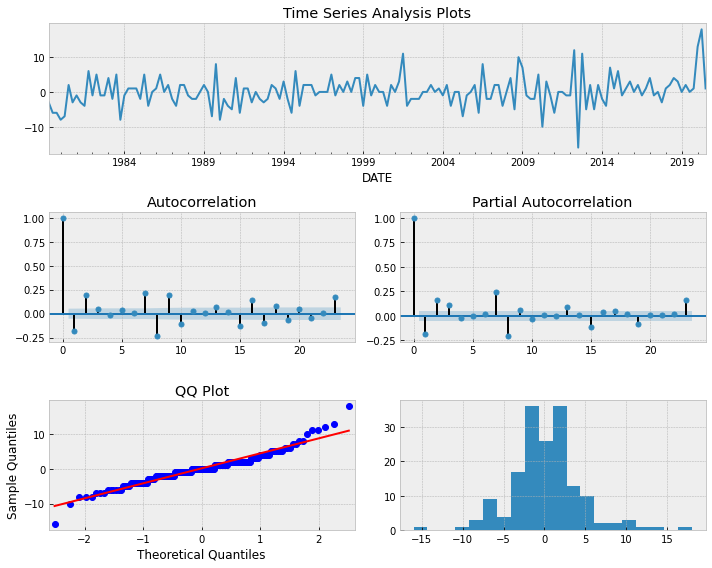

In [16]:
d1 = ts.diff()
d1 = d1[~d1.isna()]

res = adfuller(d1)

print(f"la p-value est {res[1]} << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  ")

# => stationnaire avec adfuller


res = kpss(d1)
print(f"la p-value est {res[1]} < 0.05 donc on peut rejeter H0: time series is stationary ")
tsplot(d1)

la p-value est 9.282093096302649e-18 << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  
la p-value est 0.1 < 0.05 donc on peut rejeter H0: time series is stationary 


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


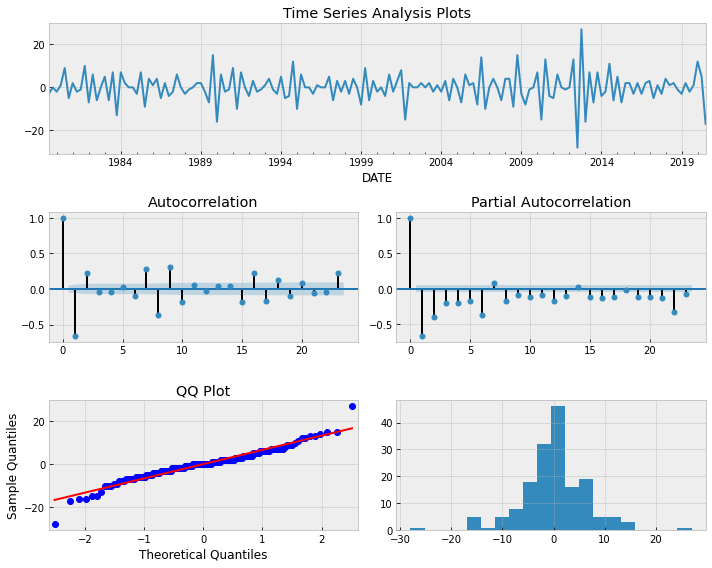

In [17]:
d2=d1.diff()
d2 = d2[~d2.isna()]

res = adfuller(d2)

print(f"la p-value est {res[1]} << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  ")

# => stationnaire avec adfuller


res = kpss(d2)
print(f"la p-value est {res[1]} < 0.05 donc on peut rejeter H0: time series is stationary ")
tsplot(d2)